### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

### Configs

In [2]:
DATA_PATH = '/Users/mpekey/Desktop/FlyVideo/Peak_Signal_Data'

FEATURES = ['pose.prob_x','pose.prob_y','pose.halt_x','pose.halt_y',
            'pose.thor_post_x','pose.thor_post_y','distance.origin-halt',
            'distance.origin-prob','distance.origin-thor_post','distance.head-prob',
            'distance.thor_post-halt','distance.avg(thor_post-joint1,thor_post-joint2,thor_post-joint3)',
            'distance.avg(origin-joint1,origin-joint2,origin-joint3)']

experiment_features = ['pose.prob_x', 'pose.prob_y', 'distance.head-prob', 'distance.origin-prob']

### Read Data

In [3]:
filename = os.path.join(DATA_PATH, 'bouts_dict.pkl')
with open(filename, 'rb') as f:
    bouts_dict = pickle.load(f)

true_peak_fn = os.path.join(DATA_PATH, 'true_peak_annotations.npy')
true_peak_df_fn = os.path.join(DATA_PATH, 'true_annotations.pkl')

true_peak_annotations_array = np.load(true_peak_fn)
with open(true_peak_df_fn, 'rb') as f:
    true_peak_annotations_df = pickle.load(f)

### Feature Engineering

#### Savitzky-Golay

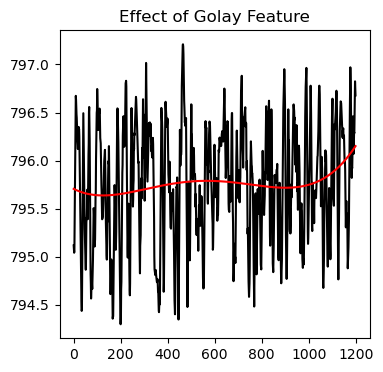

In [40]:
from scipy.signal import savgol_filter

feat = np.array(bouts_dict['Fly05182022_5d']['pose.thor_post_x'][10])
golay_feat = savgol_filter(x = feat, window_length=len(feat), polyorder=5, axis=0)

plt.figure(figsize=(4,4))
plt.plot(feat, color='black')
plt.plot(golay_feat, color='red')
plt.title(f"Effect of Golay Feature")

plt.show()

#### Moving Statistics

In [42]:
def add_mv_stats(df):
    df['moving_avg'] = df['distance.origin-prob'].rolling(window=10).mean()
    df['moving_std'] = df['distance.origin-prob'].rolling(window=10).std()
    
    # fill NaN values with its corresponding row value
    df['moving_avg'].fillna(df['distance.origin-prob'], inplace=True)
    df['moving_std'].fillna(df['distance.origin-prob'], inplace=True)
    return df

In [21]:
deneme_df

,pose.prob_x,pose.prob_y,distance.head-prob,distance.origin-prob,moving_avg,moving_std
0,758.398972,638.845390,81.299370,991.611029,991.611029,991.611029
1,758.593673,638.954418,81.560295,991.830182,991.830182,991.830182
2,758.915896,639.063446,81.779736,992.146877,992.146877,992.146877
3,759.238120,639.175227,81.985942,992.465361,992.465361,992.465361
4,758.764816,639.163016,81.841950,992.095462,992.095462,992.095462
...,...,...,...,...,...,...
2157,757.392882,641.180907,83.279075,992.349199,991.809580,0.308237
2158,757.610668,641.267826,83.419698,992.571584,991.850461,0.379222
2159,757.405298,641.456352,83.633944,992.536668,991.918738,0.436976
2160,757.233279,641.673217,83.659563,992.545595,992.001230,0.471900


### Utility Functions

In [4]:
def create_input_data(fly, experiment, features):
    
    input_data = bouts_dict[fly][features[0]][experiment].reshape(-1,1)

    for i in range(1, len(features)):
        input_data = np.concatenate((input_data,
                                    bouts_dict[fly][features[i]][experiment].reshape(-1,1)),
                                    axis=1)
    return input_data

In [55]:
def calculate_grouped_recall(predicted_peaks, true_peaks, matching_range):
    recall_predictions = []
    for true_idx in true_peaks:
        found_true_pred = False
        for pred_idx in predicted_peaks:
            if abs(pred_idx - true_idx) <= matching_range:
                found_true_pred = True
                break
        recall_predictions.append(found_true_pred)
    recall = np.sum(recall_predictions) / len(recall_predictions)
    return recall

def calculate_grouped_precision(predicted_peaks, true_peaks, matching_range):
    precision_predictions = []
    for pred_idx in predicted_peaks:
        found_pred = False
        for true_idx in true_peaks:
            if abs(pred_idx - true_idx) <= matching_range:
                found_pred = True
                break
        precision_predictions.append(found_pred)
    precision = np.sum(precision_predictions) / len(precision_predictions)
    return precision

def calculate_f1_score(precision, recall):
    if precision + recall > 0.0:
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0.0


def evaluate_results(all_results, matching_range = 30):
    avg_recall, avg_precision, avg_f1_score = 0, 0, 0
    all_recall, all_precision, all_f1_score = [], [], []

    for res in all_results:
        predicted_peaks = res['predicted_index']
        true_peaks = res['true_index']
        
        recall = calculate_grouped_recall(predicted_peaks, true_peaks, matching_range)
        precision = calculate_grouped_precision(predicted_peaks, true_peaks, matching_range)
        f1_score = calculate_f1_score(precision, recall)
        
        all_recall.append(recall)
        all_precision.append(precision)
        all_f1_score.append(f1_score)

        avg_recall += recall
        avg_precision += precision
        avg_f1_score += f1_score

    avg_recall /= len(all_results)
    avg_precision /= len(all_results)
    avg_f1_score /= len(all_results)
    
    return {
        'avg_metrics' : {
            'avg_recall' : avg_recall,
            'avg_precision' : avg_precision,
            'avg_f1_score' : avg_f1_score
            },
        'all_metrics' : {
            'all_recall' : all_recall,
            'all_precision' : all_precision,
            'all_f1_score' : all_f1_score
            }
        }

In [6]:
def filter_prediction(anomalies, grouped_range=60):
    idx_group = []
    all_groups = []
    for idx in list(anomalies.index):
        if idx in idx_group:
            continue
        idx_group = []
        for i in range(idx, idx+grouped_range):
            if i in list(anomalies.index):
                idx_group.append(i)
        all_groups.append(idx_group)
    
    group_pred_idx = []
    group_pred_val = []
    for group in all_groups:
        group_vals = anomalies.loc[group]['distance.origin-prob']
        if len(group_vals) > 1 and group_vals.iloc[0] < group_vals.iloc[1]:
            pred = group_vals[group_vals == group_vals.max()]
        else:
            pred = group_vals[group_vals == group_vals.min()]
        group_pred_idx.append(pred.index.values[0])
        group_pred_val.append(pred.values[0])
    return group_pred_idx, group_pred_val

### Fly Class

In [7]:
class FlyInfo:
    def __init__(self, name, trial_id, peak_index, peak_values):
        self.name = name
        self.trial_id = trial_id
        self.peak_index = peak_index
        self.peak_values = peak_values

class FlyDatabase:
    def __init__(self):
        self.fly_data = []

    def add_fly(self, fly_info):
        self.fly_data.append(fly_info)

    def get_fly(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                return fly_info
        return None
    
    def write_fly_info(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                print('Name:', fly_info.name)
                print('Trial Id:', fly_info.trial_id)
                print('Peak Index:', fly_info.peak_index)
                print('Peak Values:', fly_info.peak_values)
                return None
        print('Fly not found!!!')
        return None

In [8]:
fly_db = FlyDatabase()

fly_names = true_peak_annotations_df['name'].unique()

for name in fly_names:
    trial_idxs = true_peak_annotations_df[true_peak_annotations_df['name'] == name]['trial_id'].unique().tolist()
    for idx in trial_idxs:
        peak_index = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['peak_index'].values
        peak_values = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['value'].values
        fly_db.add_fly(FlyInfo(name, idx, peak_index, peak_values))

fly_db.write_fly_info('Fly05182022_5d', '0')

Name: Fly05182022_5d
Trial Id: 0
Peak Index: [ 534  694  903 1207 1623]
Peak Values: [1014.36112044 1017.73376888 1027.22816309 1021.72159098 1023.54593544]


In [9]:
peak_ratios = []
for fly in fly_db.fly_data:
    data_length = len(bouts_dict[fly.name].loc[int(fly.trial_id)]['distance.origin-prob'])
    peak_amount = len(fly.peak_index)
    peak_ratios.append(peak_amount / data_length)

peak_ratio = np.mean(peak_ratios)
max_ratio = np.max(peak_ratios)
min_ratio = np.min(peak_ratios)

print(f'Ratio: {peak_ratio}, Min: {min_ratio}, Max: {max_ratio}')

Ratio: 0.003377344961379769, Min: 0.00030807147258163895, Max: 0.01078167115902965


### Evaluation

In [52]:
def create_config(features = ['distance.origin-prob','distance.head-prob', 'pose.prob_x','pose.prob_y'],
                  contamination = 0.04,
                  grouped_range = 60,
                  add_golay = False,
                  add_mv_stats = False):
    config = {}
    config['features'] = features
    config['contamination'] = contamination
    config['grouped_range'] = grouped_range
    config['add_golay'] = add_golay
    config['add_mv_stats'] = add_mv_stats
    return config

In [64]:
def get_model_prediction(fly, config):
    input_data = create_input_data(fly = fly.name,
                                    experiment = int(fly.trial_id),
                                    features = config['features'])

        
    info_df = pd.DataFrame(input_data, columns = config['features'])

    if config['add_mv_stats']:
        info_df = add_mv_stats(info_df)
    
    if config['add_golay']:
        golay_cols = ['pose.thor_post_x', 'pose.thor_post_y']
        for col in golay_cols:
            feat = bouts_dict[fly.name][col][int(fly.trial_id)]
            info_df[f'gol_{col}'] = savgol_filter(x = feat, window_length=len(feat), polyorder=5, axis=0)
        
    input_data = info_df.to_numpy()

    scaled_data = StandardScaler().fit_transform(input_data)
    model = IsolationForest(n_estimators = 100,
                            contamination=config['contamination'],
                            max_samples='auto',
                            max_features=1.0,
                            bootstrap=False)
    info_df['predictions'] = model.fit_predict(scaled_data)
    return info_df

In [63]:
def evaluate_model(config):
    all_results, all_results_group = [], []

    for fly in fly_db.fly_data:
        info_df = get_model_prediction(fly, config)
        
        anomalies = info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']]
        anomalies_idx = list(anomalies.index)

        group_pred_idx, group_pred_val = filter_prediction(anomalies, grouped_range=config['grouped_range'])
        
        all_results.append({'true_index': fly.peak_index, 'predicted_index': anomalies_idx})
        all_results_group.append({'true_index': fly.peak_index, 'predicted_index': group_pred_idx})

    results = evaluate_results(all_results)
    results_g = evaluate_results(all_results_group)

    return results, results_g

In [56]:
config = create_config(add_golay = False, add_mv_stats = False)
results, results_g = evaluate_model(config)

print(results['avg_metrics'])
print('##################')
print(results_g['avg_metrics'])

{'avg_recall': 0.824343516556657, 'avg_precision': 0.7641359112210911, 'avg_f1_score': 0.7719400768327089}
##################
{'avg_recall': 0.8068331418574408, 'avg_precision': 0.7601770611668932, 'avg_f1_score': 0.7593967526681433}


In [57]:
config = create_config(add_golay = True, add_mv_stats = False)
results, results_g = evaluate_model(config)

print(results['avg_metrics'])
print('##################')
print(results_g['avg_metrics'])

{'avg_recall': 0.7721919408188658, 'avg_precision': 0.7296479719989039, 'avg_f1_score': 0.7283285782652783}
##################
{'avg_recall': 0.7582748731464334, 'avg_precision': 0.719375382184648, 'avg_f1_score': 0.7125796763227661}


In [58]:
config = create_config(add_golay = False, add_mv_stats = True)
results, results_g = evaluate_model(config)

print(results['avg_metrics'])
print('##################')
print(results_g['avg_metrics'])

{'avg_recall': 0.7845541098428631, 'avg_precision': 0.7417716249766428, 'avg_f1_score': 0.7403865835177873}
##################
{'avg_recall': 0.7707420456552624, 'avg_precision': 0.7101445065705989, 'avg_f1_score': 0.7145278836958254}


In [59]:
config = create_config(add_golay = True, add_mv_stats = True)
results, results_g = evaluate_model(config)

print(results['avg_metrics'])
print('##################')
print(results_g['avg_metrics'])

{'avg_recall': 0.7474741383192529, 'avg_precision': 0.7039745114737563, 'avg_f1_score': 0.7020526155728218}
##################
{'avg_recall': 0.7330096507324476, 'avg_precision': 0.6719372156178491, 'avg_f1_score': 0.6748958096458619}


In [74]:
def log_bad_predictions(bad_pred_idx_list, config):
    for bad_idx in bad_pred_idx_list:
        fly = fly_db.fly_data[bad_idx]
        info_df = get_model_prediction(fly, config)

        anomalies = info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']]
        anomalies_idx = list(anomalies.index)
        group_pred_idx, group_pred_val = filter_prediction(anomalies, grouped_range=60)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes = axes.flatten()

        axes[0].plot(info_df.index, info_df[model_features[0]], color='black', label = 'Normal')
        axes[0].scatter(anomalies.index, anomalies[model_features[0]], color='red', label = 'Anomaly')
        axes[1].plot(info_df.index, info_df[model_features[0]], color='black', label = 'Normal')
        axes[1].scatter(group_pred_idx, group_pred_val, color='red', label = 'Anomaly')


        for true_peaks in fly.peak_index:
            min_range, max_range = true_peaks - 30, true_peaks + 30
            axes[0].axvspan(min_range, max_range, color='yellow', alpha=0.3)
            axes[1].axvspan(min_range, max_range, color='yellow', alpha=0.3)

        axes[0].set_title("Method 1 - All Predictions")
        axes[0].legend(fontsize='small')
        axes[1].set_title("Method 2 - Filtered Predictions")
        axes[1].legend(fontsize='small')
        plt.tight_layout()
        plt.show()

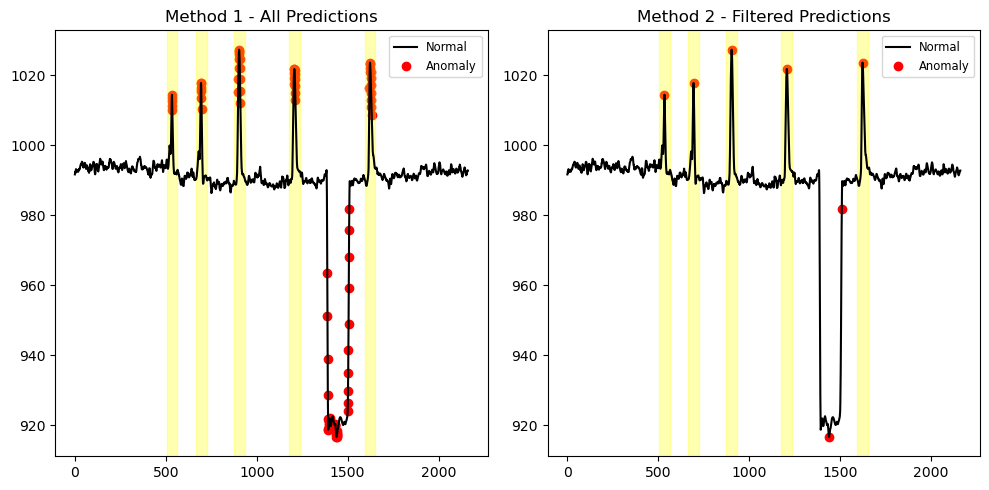

In [75]:
log_bad_predictions([0], config)

### Hocanin dedigi gibi range icinde labellar yaratarak dene